In [5]:
import numpy as np
from utils import COLORS, load_image
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [6]:
image_path = "./test.jpg"
image = load_image(image_path)
image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))
_mean = np.mean(image_pixels, axis=0, keepdims=True)
_std = np.std(image_pixels, axis=0, keepdims=True)
image_pixels = (image_pixels - _mean) / _std # Normalization

ncomp = int(3)

kmeans = KMeans(n_clusters=ncomp)
labels = kmeans.fit_predict(image_pixels)
initial_mus = kmeans.cluster_centers_
initial_priors, initial_covs = [], []
for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_priors.append(datas.shape[1] / float(len(labels)))

In [7]:
class GMM:
    def __init__(self, n_clusters, init_mus, init_covs, init_priors):
        self.n_clusters = n_clusters
        self.mus = np.array(init_mus)
        self.covs = np.array(init_covs)
        self.priors = np.array(init_priors)

    def inference(self, data):
        unnormalized_probs = []
        for i in range(self.n_clusters):
            mu = self.mus[i, :]
            cov = self.covs[i, :, :]
            prior = self.priors[i]
            unnormalized_prob = prior * \
                multivariate_normal.pdf(data, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        pred = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(np.log(np.sum(pred, axis=1)))
        pred = pred / np.sum(pred, axis=1, keepdims=True)
        return np.array(pred), log_likelihood

    def update(self, data, beliefs):
        soft_counts = np.sum(beliefs, axis=0)
        new_mus = []
        new_covs = []
        new_priors = []
        for i in range(self.n_clusters):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * data, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)
            data_shifted = np.subtract(data, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(
                np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)
            new_priors.append(soft_counts[i]/np.sum(soft_counts))
        self.mus = np.array(new_mus)
        self.covs = np.array(new_covs)
        self.priors = np.array(new_priors)

iteration 1: Log likelihood = -197843.0393006949
iteration 2: Log likelihood = -126127.74757284323
iteration 3: Log likelihood = -99887.92487783877
iteration 4: Log likelihood = -80372.35384910034
iteration 5: Log likelihood = -26539.813208420732
iteration 6: Log likelihood = 127274.1023530689
iteration 7: Log likelihood = 213624.34977569326
iteration 8: Log likelihood = 245239.2183226289
iteration 9: Log likelihood = 264548.8297649399
iteration 10: Log likelihood = 279696.679310198
iteration 11: Log likelihood = 291433.23896255554
iteration 12: Log likelihood = 299069.78490788693
iteration 13: Log likelihood = 303280.8764242228
iteration 14: Log likelihood = 305435.91823874944
iteration 15: Log likelihood = 306538.3948340454
iteration 16: Log likelihood = 307120.4222748568
iteration 17: Log likelihood = 307438.92199609
iteration 18: Log likelihood = 307618.4622268141
iteration 19: Log likelihood = 307721.9738263614
iteration 20: Log likelihood = 307782.6989361878
iteration 21: Log lik

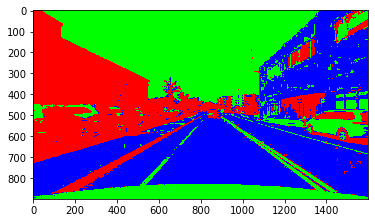

In [8]:
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)

# EM Algorithm
prev_log_likelihood = None
for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
    gmm.update(image_pixels, beliefs) # M-step
    print('iteration {}: Log likelihood = {}'.format(i + 1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood

# Show Result
beliefs, log_likelihood = gmm.inference(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
segmented_map = np.zeros((image_height, image_width, 3))
for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()

In [9]:
plt.savefig('./result.jpg')

<Figure size 432x288 with 0 Axes>